<h4>Imports</h4>

In [5]:
#NOTE: autoreload is not recursive, only direct imports are reloaded
%load_ext autoreload
%autoreload 2
from data_translator import TestTranslator, EncodeForGA, GAToScheduleTranslator
from hybrid_solution_data_loader import get_data
from models import Order, SimulationEnvironment, Schedule
from solver import GASolver, PSOSolver, GreedyAgentSolver
from visualize import visualize_schedule_demo
import objective_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Config

In [6]:
available_solvers = ["GASolver", "PSOSolver", "GreedyAgentSolver"]
use_solver = available_solvers[0]
save_file = False
file_name = 'just_testing' # NOTE: only change this name for saving files

full_name = f'{file_name}_{use_solver}'

<h4>Read from Source</h4>

In [7]:
n_workstations, recipes, operation_times = get_data(3)
recipies, workstations, resources, tasks, _ = TestTranslator().translate(n_workstations, recipes, operation_times)

env = SimulationEnvironment(workstations, tasks, resources, recipies)

<h4>Create Orders</h4>

In [8]:
earliest_slot = 0
last_slot = 100
recipe_orders = [0, 1, 2, 3, 0, 3, 2, 1, 0, 3] # for dataset 0
orders = []
o_id = 0
for order in recipe_orders:
    orders.append(Order(o_id, 0, last_slot, last_slot, [order], 100, 50, False, 0, False, 500)) # for now: use resources to select recipe
    o_id = o_id + 1


<h4>Translate for Solver</h4>

In [9]:
if use_solver == "GASolver" or use_solver == "PSOSolver" or use_solver == "GreedyAgentSolver": # NOTE: all solvers use the same encoding right now
    # translate datamodel to encoding
    encoder = EncodeForGA()
    values, durations, all_jobs = encoder.translate(env, orders) # encoding, duration lookup table, list of all jobs used (probably not needed), possible alternatives for each job


<h4>Run Solver</h4>

GA

In [10]:
if use_solver == "GASolver":
    #NOTE: Best makespan so far: 22 for dataset 0 
    crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
    selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stochastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
    mutation = 'workstation_only' #NOTE: available options: 'workstation_only', 'full_random', 'random_only_feasible' #NOTE 2: so far only workstation_only can find feasible results
    objective = 'makespan' #NOTE: available options: 'makespan', 'idle_time'
    population_size = 50
    offspring_amount = 100
    max_generations = 2000

    solver = GASolver(values, durations, all_jobs, env, orders)
    solver.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation, objective=objective)
    solver.run()

Done


In [11]:
if use_solver == "GASolver":
    # just for comparison, so the optimizers don't have to run over and over again
    ga_result = solver.get_best()
    ga_fitness = solver.get_best_fitness()

PSO 

In [12]:
if use_solver == "PSOSolver":
    #NOTE: no best makespan yet
    solver = PSOSolver(values, durations, all_jobs, env, orders)

    #solver.initialize(earliest_slot, last_slot, c1=0.5, c2=0.3, w=0.5, max_iter=5000)
    solver.initialize(earliest_slot, last_slot, c1=2, c2=2, w=0.1, max_iter=25000) # 'widely used values for integer optimization' https://www.researchgate.net/publication/3949434_Particle_swarm_optimization_for_integer_programming
    solver.run()

In [13]:
if use_solver == "PSOSolver":
    # just for comparison, so the optimizers don't have to run over and over again
    pso_result = solver.get_best()
    pso_fitness = solver.get_best_fitness()

Greedy Agent

In [14]:
if use_solver == "GreedyAgentSolver":
    #NOTE: Best makespan so far: 26 for dataset 0
    solver = GreedyAgentSolver(values, durations, all_jobs, env, orders)
    solver.run()

In [15]:
if use_solver == "GreedyAgentSolver":
    # just for comparison, so the optimizers don't have to run over and over again
    greedy_result = solver.get_best()
    greedy_fitness = solver.get_best_fitness()

<h4>Result Output</h4>

In [16]:
result = solver.get_best()
fitness = solver.get_best_fitness()
#result = greedy_result
#fitness = greedy_fitness
#result = pso_result
#fitness = pso_fitness
#result = ga_result
#fitness = ga_fitness

print("Parameters of the best solution : {solution}".format(solution=result))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(fitness)))
fitness_history = solver.assignments_best
average_fitness_history = solver.average_assignments


Parameters of the best solution : [ 6  0  0  2  8  3  8  6  1  0  4  8  7 13  0 16  3  0  3  5  1  9  9 11
  1 11  9 13  0 25  8 34  6  2  8 10  5 14  9 23  5 23  5 25  2 27  5 29
  4 13  8 17  4 18  6 25  3  9  3 10  4 25  4 29  4 31  1 34  0 35  8 37
  3 17  3 21  6 33  1 36]
Fitness value of the best solution = 41


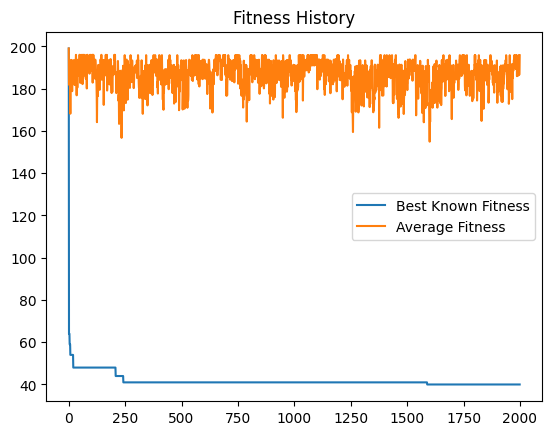

In [17]:
import matplotlib.pyplot as plt
if not len(fitness_history) == 0 and not len(average_fitness_history) == 0:
    x = list(range(0, len(fitness_history)))
    plt.plot(x, fitness_history)
    plt.plot(x, average_fitness_history)
    plt.title('Fitness History')
    plt.legend(['Best Known Fitness', 'Average Fitness'])
    plt.xlabel = 'Generation'
    plt.ylabel = 'Fitness'
    plt.show()

<h4>(Optional) Postprocessing</h4>

<h4>Translate to Schedule</h4>

In [18]:
schedule = GAToScheduleTranslator().translate(result, all_jobs, env, orders)
schedule.created_in = env
schedule.created_for = orders

<h4>Visualize Schedule</h4>

In [19]:
visualize_schedule_demo(schedule, env, orders)

<h4>Evaluate Schedule</h4>

In [20]:
#NOTE: the objective functions in this case assume the solution is feasible, no additional checks
#NOTE: currently the only objective function used during optimization is makespan
makespan, tardiness, deviation, idle_time, profit = objective_function.calculate_comparison_values(schedule, orders, env)
print(f'Fitness Values:\nMakespan: {makespan}\nTardiness: {tardiness}\nDeviation: {deviation}\nIdle Time: {idle_time}\nProfit: {profit}')

Fitness Values:
Makespan: 41
Tardiness: 0
Deviation: 708
Idle Time: 164
Profit: 5000


(Optional) Save Result as .pickle file for later comparison

In [21]:
import pickle

solver.environment = None # make file smaller, since the schedule already knows the environment and the orders
solver.orders = None
schedule.created_by = solver
schedule.evaluation_results = []
schedule.evaluation_results.append(('makespan', makespan))
schedule.evaluation_results.append(('tardiness', tardiness))
schedule.evaluation_results.append(('deviation', deviation))
schedule.evaluation_results.append(('idle_time', idle_time))
schedule.evaluation_results.append(('profit', profit))

if(save_file):
    with open(f'results/{full_name}.pickle', 'wb') as outfile:
        pickled_data = pickle.dump(schedule, outfile)


<h1> ####### MAS TESTING SECTION #######  </h1>

In [22]:
from mas import MAS
# GA config
crossover = 'two_points' #NOTE: available in PyGAD: 'two_points', 'single_point', 'uniform', 'scattered'
selection = 'rws' #NOTE: available in PyGAD: 'sss' (steady state selection', 'rws' (roulette wheel), 'sus' (stochastic universal selection), 'rank' (rank selection), 'random' (random selection), 'tournament' (tournament selection)
mutation = 'workstation_only' #NOTE: available options: 'workstation_only', 'full_random', 'random_only_feasible' #NOTE 2: so far only workstation_only can find feasible results

population_size = 50
offspring_amount = 100
max_generations = 2000
s1 = GASolver(values, durations, all_jobs, env, orders)
s1.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation, objective='makespan')
s2 = GASolver(values, durations, all_jobs, env, orders)
s2.initialize(earliest_slot, last_slot, population_size, offspring_amount, max_generations, crossover=crossover, selection=selection, mutation=mutation, objective='idle_time')
s3 = GreedyAgentSolver(values, durations, all_jobs, env, orders)

mas = MAS()
mas.add_solver(s1, GAToScheduleTranslator())
mas.add_solver(s2, GAToScheduleTranslator())
mas.add_solver(s3, GAToScheduleTranslator())

In [23]:
schedule = mas.run(env=env, jobs=all_jobs, orders=orders, parallel=False) # NOTE: parallel runs can be problematic with jupyter notebooks

Done
Done
Done


In [24]:
def show_result(result : tuple) -> None:
    print('####################################################################################################')
    print(f'Created with {result[0].created_by.name} for objective: {result[0].created_by.objective}')
    visualize_schedule_demo(result[0], env, orders)
    print(f'Fitness Values:\nMakespan: {result[1][0]}\nTardiness: {result[1][1]}\nDeviation: {result[1][2]}\nIdle Time: {result[1][3]}\nProfit: {result[1][4]}')

In [25]:
show_result(schedule)

####################################################################################################
Created with GASolver for objective: makespan


Fitness Values:
Makespan: 32
Tardiness: 0
Deviation: 774
Idle Time: 93
Profit: 5000


In [87]:
import matplotlib.pyplot as plt

def remap(value, from_lb, from_ub, to_lb, to_ub):
    oldRange = from_ub - from_lb
    newRange = to_ub - to_lb
    mapped = (((value - from_lb) * newRange) / oldRange) + to_lb
    return mapped

def compare_results(results : list[tuple]) -> None:
    makespan = []
    idle_time = []
    deviation = []
    max_makespan = 0
    min_makespan = float('inf')
    max_idle_time = 0
    min_idle_time = float('inf')
    max_deviation = 0
    min_deviation = float('inf')
     
    for result in results:
        makespan.append(result[1][0])
        idle_time.append(result[1][3])
        deviation.append(result[1][2])
        if result[1][0] > max_makespan:
            max_makespan = result[1][0]
        if result[1][3] > max_idle_time:
            max_idle_time = result[1][3]
        if result[1][2] > max_deviation:
            max_deviation = result[1][2]
        if result[1][0] < min_makespan:
            min_makespan = result[1][0]
        if result[1][3] < min_idle_time:
            min_idle_time = result[1][3]
        if result[1][2] < min_deviation:
            min_deviation = result[1][2]
    # remapping range for value comparison
    lb = 0
    ub = 10
    makespan_remapped = [remap(x, min_makespan, max_makespan, lb, ub) for x in makespan]
    idle_time_remapped = [remap(x, min_idle_time, max_idle_time, lb, ub) for x in idle_time]
    deviation_remapped = [remap(x, min_deviation, max_deviation, lb, ub) for x in deviation]
    print('Comparisons')
    # makespan, idle_time
    ax_makespan_idle_time = plt.figure().add_subplot()
    ax_makespan_idle_time.set_xlabel('Makespan')
    ax_makespan_idle_time.set_ylabel('Idle Time')
    ax_makespan_idle_time.scatter(makespan, idle_time)
    plt.title('Makespan and Idle Time')
    # makespan, deviation
    ax_makespan_deviation = plt.figure().add_subplot()
    ax_makespan_deviation.set_xlabel('Makespan')
    ax_makespan_deviation.set_ylabel('Deviation')
    ax_makespan_deviation.scatter(makespan, deviation)
    plt.title('Makespan and Deviation')
    # idle_time, deviaton
    ax_idle_time_deviation = plt.figure().add_subplot()
    ax_idle_time_deviation.set_xlabel('Idle Time')
    ax_idle_time_deviation.set_ylabel('Deviation')
    ax_idle_time_deviation.scatter(idle_time, deviation)
    plt.title('Idle Time and Deviation')
    plt.show()

    print(f'Comparisons with remapped values to lb: {lb} and ub: {ub}')
    # makespan, idle_time
    ax_makespan_idle_time_remapped = plt.figure().add_subplot()
    ax_makespan_idle_time_remapped.set_xlabel('Makespan')
    ax_makespan_idle_time_remapped.set_ylabel('Idle Time')
    ax_makespan_idle_time_remapped.scatter(makespan_remapped, idle_time_remapped)
    ax_makespan_idle_time_remapped.plot([0, ub], [ub, 0])
    plt.title('Makespan and Idle Time with remapped values')
    # makespan, deviation
    ax_makespan_deviation_remapped = plt.figure().add_subplot()
    ax_makespan_deviation_remapped.set_xlabel('Makespan')
    ax_makespan_deviation_remapped.set_ylabel('Deviation')
    ax_makespan_deviation_remapped.scatter(makespan_remapped, deviation_remapped)
    ax_makespan_deviation_remapped.plot([0, ub], [ub, 0])
    plt.title('Makespan and Deviation with remapped values')
    # idle_time, deviaton
    ax_idle_time_deviation_remapped = plt.figure().add_subplot()
    ax_idle_time_deviation_remapped.set_xlabel('Idle Time')
    ax_idle_time_deviation_remapped.set_ylabel('Deviation')
    ax_idle_time_deviation_remapped.scatter(idle_time_remapped, deviation_remapped)
    ax_idle_time_deviation_remapped.plot([0, ub], [ub, 0])
    plt.title('Idle Time and Deviation with remapped values')
    plt.show()

    print('Comparison using makespan, idle_time and deviation')
    ax = plt.figure().add_subplot(projection='3d')

    x = []
    y = []
    z = []
    for result in results:
        x.append(makespan_remapped) # makespan
        y.append(idle_time_remapped) # idle time
        z.append(deviation_remapped) # deviation

    ax.scatter(x, y, z)
    ax.set_xlabel('Makespan')
    ax.set_ylabel('Idle Time')
    ax.set_zlabel('Deviation')
    plt.show()

Comparisons


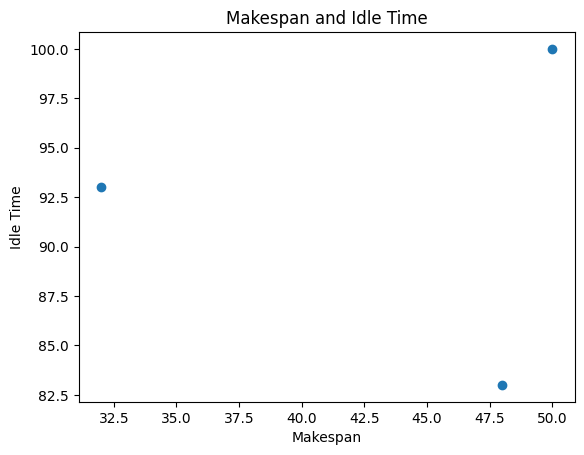

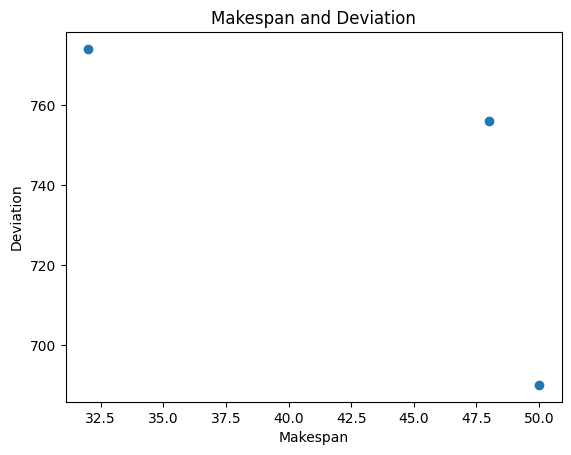

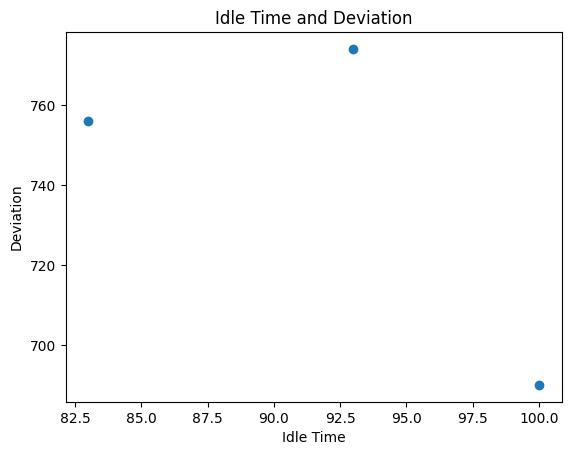

Comparisons with remapped values to lb: 0 and ub: 10


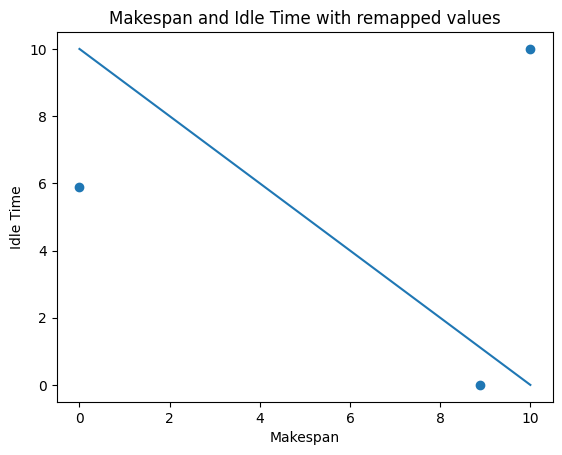

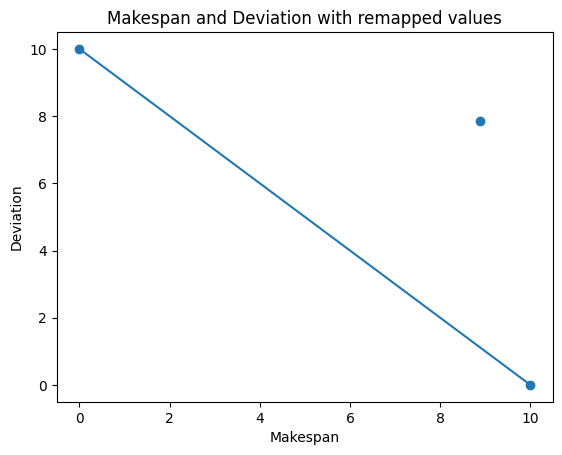

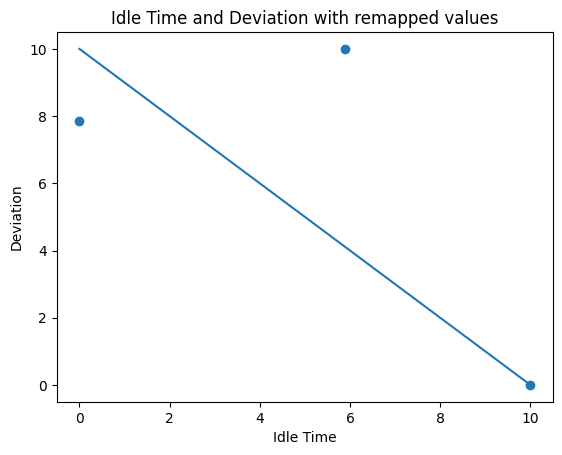

Comparison using makespan, idle_time and deviation


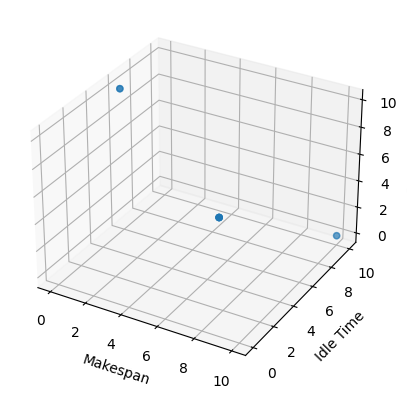

####################################################################################################
Created with GASolver for objective: makespan


Fitness Values:
Makespan: 32
Tardiness: 0
Deviation: 774
Idle Time: 93
Profit: 5000
####################################################################################################
Created with GASolver for objective: idle_time


Fitness Values:
Makespan: 48
Tardiness: 0
Deviation: 756
Idle Time: 83
Profit: 5000
####################################################################################################
Created with GreedyAgentSolver for objective: makespan


Fitness Values:
Makespan: 50
Tardiness: 0
Deviation: 690
Idle Time: 100
Profit: 5000

Dominance Values:
GASolver, makespan: 3
GASolver, idle_time: 3
GreedyAgentSolver, makespan: 3


In [88]:
all_results = mas.get_all_results()

for result in all_results:
    show_result(result)

print(f'\nDominance Values:')
for i in range(len(all_results)):
    print(f'{all_results[i][0].created_by.name}, {all_results[i][0].created_by.objective}: {mas.get_dominance(all_results, i)}')